In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     |████████████████████████████████| 216 kB 19.9 MB/s 
     |████████████████████████████████| 133 kB 52.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 18.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [3]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [47]:
positive_words = 'love', 'great', 'best', 'wonderful', 'well', 'fine', 'excellent'#, 'homely', 'kind', 'satisfactory', 'pretty', 'nice', 'good' 
negative_words = 'worst', 'awful', '1/10', 'crap', 'bad', 'poor', 'inferior', 'cheap', 'two-bit'

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 71.72%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [48]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

In [49]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

In [56]:
train_df['review'].iloc[3]

'Spoilers ahead if you want to call them that...  I would almost recommend this film just so people can truly see a 1/10. Where to begin, we\'ll start from the top...  THE STORY: Don\'t believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It\'s a draub, basic, go to cabin movie with no intensity or "effort".  THE SCREENPLAY: I usually give credit to indie screenwriters, it\'s hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you\'d uh...if you\'d like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.  THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one step further and say that they ac

In [91]:
def removeApostrophe(review):
    review = review.lower()
    review = re.sub(r"don't", "do not", review)
    review = re.sub(r"won't", "will not", review)
    review = re.sub(r"can\'t", "can not", review)
    review = re.sub(r"n\'t", " not", review)
    review = re.sub(r"\'re", " are", review)
    review = re.sub(r"\'s", " is", review)
    review = re.sub(r"\'d", " would", review)
    review = re.sub(r"\'ll", " will", review)
    review = re.sub(r"\'t", " not", review)
    review = re.sub(r"\'ve", " have", review)
    review = re.sub(r"\'m", " am", review)
    return review

def removeApostropheFixed(review):
    review = review.lower()
    review = re.sub(r"don\'t", "do not", review)
    review = re.sub(r"won't", "willnot", review)
    review = re.sub(r"can\'t", "cannot", review)
    review = re.sub(r"\snot", "not", review)
    review = re.sub(r"n\'t", "not", review)
    review = re.sub(r"\'re", " are", review)
    review = re.sub(r"\'s", " is", review)
    review = re.sub(r"\'d", " would", review)
    review = re.sub(r"\'ll", " will", review)
    review = re.sub(r"\'t", " not", review)
    review = re.sub(r"\'ve", " have", review)
    review = re.sub(r"\'m", " am", review)
    return review


In [92]:
removeApostrophe(train_df['review'].iloc[3])

'spoilers ahead if you want to call them that...  i would almost recommend this film just so people can truly see a 1/10. where to begin, we will start from the top...  the story: do not believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. it is a draub, basic, go to cabin movie with no intensity or "effort".  the screenplay: i usually give credit to indie screenwriters, it is hard work when you are starting out...but this is crap. the story is flat - it leaves you emotionless the entire movie. the dialogue is extremely weak and predictable boasting lines of "woah, you totally freaked me out" and "i was wondering if you would uh...if you would like to..uh, would you come to the cabin with me?". it makes me want to rip out all my hair, one strand at a time and feed it to myself.  the characters: holy crap!!!! some have described the characters as flat, i want to take it one step further and say that 

In [99]:
train_df['review2'] = train_df['review'].apply(lambda x: removeApostrophe(x))

In [117]:
test_df['review2'] = test_df['review'].apply(lambda x: removeApostrophe(x))

In [100]:
train_df.head()

,is_positive,review,review2
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite its fistful of tony wins i..."
1,0,This show comes up with interesting locations ...,this show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,i simply love this movie. i also love the ramo...
3,0,Spoilers ahead if you want to call them that.....,spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...,my all-time favorite movie! i have seen many m...


Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [101]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [103]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review2'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [104]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [105]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x75772 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Получилось что надо.

Запустим теперь её на реальных данных.

In [111]:
model.fit(train_df['review2'], train_df['is_positive'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [118]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review2'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.58%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [119]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.697,refreshing
+1.680,wonderfully
+1.670,funniest
+1.608,surprisingly
+1.601,rare
+1.505,superb
+1.357,incredible
+1.319,perfect
+1.287,excellent
+1.254,subtle


Посмотрим на конкретные примеры его работы:

In [120]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review2'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [121]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review2'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [122]:
import numpy as np

preds = model.predict(test_df['review2'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review2'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review2'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.41%


In [124]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review2'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [130]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review2'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.76%


In [131]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review2'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [132]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review2'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.78%


In [133]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review2'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [137]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [149]:
for token in docs[0][:10]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls B GPE
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE


In [147]:
docs[0][0].lemma_

'Dreamgirls'

In [150]:
docs = [doc for doc in nlp.pipe(train_df.review.values)]

In [185]:
train_df['lemmas'] = 'gh'
train_df['ner_lemmas'] = 'gh'
lemmas_list_temp = []
ner_list_temp = [] 

for i, doc in enumerate(docs):
  lemmas_list = []
  ner_list = []  
  for token in doc:
    lemmas_list.append(token.lemma_)
    if token.ent_type_ == '':
      ner_list.append(token.lemma_)
    else:
      ner_list.append(token.ent_type_)
  lemmas_list_temp.append(' '.join(lemmas_list))
  ner_list_temp.append(' '.join(ner_list))

train_df['lemmas'] = lemmas_list_temp
train_df['ner_lemmas'] = ner_list_temp 

In [187]:
docs = [doc for doc in nlp.pipe(test_df.review.values)]
test_df['lemmas'] = 'gh'
test_df['ner_lemmas'] = 'gh'
lemmas_list_temp = []
ner_list_temp = [] 

for i, doc in enumerate(docs):
  lemmas_list = []
  ner_list = []  
  for token in doc:
    lemmas_list.append(token.lemma_)
    if token.ent_type_ == '':
      ner_list.append(token.lemma_)
    else:
      ner_list.append(token.ent_type_)
  lemmas_list_temp.append(' '.join(lemmas_list))
  ner_list_temp.append(' '.join(ner_list))

test_df['lemmas'] = lemmas_list_temp
test_df['ner_lemmas'] = ner_list_temp 

In [186]:
train_df.head(5)

,is_positive,review,review2,lemmas,ner_lemmas
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite its fistful of tony wins i...","Dreamgirls , despite its fistful of Tony win i...","GPE , despite its fistful of PERSON win in DAT..."
1,0,This show comes up with interesting locations ...,this show comes up with interesting locations ...,this show come up with interesting location as...,this show come up with interesting location as...
2,1,I simply love this movie. I also love the Ramo...,i simply love this movie. i also love the ramo...,I simply love this movie . I also love the Ram...,I simply love this movie . I also love the NOR...
3,0,Spoilers ahead if you want to call them that.....,spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call they that .....
4,1,My all-time favorite movie! I have seen many m...,my all-time favorite movie! i have seen many m...,my all - time favorite movie ! I have see many...,my all - time favorite movie ! I have see many...


In [188]:
test_df.head(5)

,is_positive,review,review2,lemmas,ner_lemmas
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,a formulaic story with all the tired cliche . ...
1,1,This is both an entertaining and a touching ve...,this is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,this be both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...,corey haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,PERSON PERSON be never go to be know as one of...
3,1,If you believe that any given war movie can ma...,if you believe that any given war movie can ma...,if you believe that any give war movie can mak...,if you believe that any give war movie can mak...
4,1,Carla Gugino literally melts the screen in thi...,carla gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,PERSON PERSON literally melt the screen in thi...


In [189]:
def eval_model(model, test_df, col_name_to_test):
    preds = model.predict(test_df[col_name_to_test])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

In [190]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmas'], train_df['is_positive'])

eval_model(model, test_df, 'lemmas')

Test accuracy = 88.16%


**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [195]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('comes'))

becom
becom
come


**Задание** Попробуйте вместо лемм классифицировать основы.

In [214]:
' '.join([stemmer.stem(word) for word in train_df['review'][0].split()])

'dreamgirls, despit it fist of toni win in an incred weak year on broadway, ha never been what one would call a jewel in the crown of stage musicals. however, that is not to say that in the right cinemat hand it could not be flesh out and polish into someth worthwhil on-screen. unfortunately, what transfer to the screen is basic a slavishli faith version of the stage hit with all of it inher weak intact. first, the score ha never been one of the strong point of thi product and the film doe not chang that factor. there are lot of song (perhap too many?), but few of them are especi memorable. the closest ani come to catchi tune are the titl song and one night onli - the much acclaim and i am tell you that i am not go is less a great song than it is a dramat set piec for the charact of effi (jennif hudson). the film is slick and technic well-produced, but the stori and charact are surprisingli thin and lack in ani resonance. there is some interest in the open moments, watch jami foxx\' sv

In [215]:
train_df['stem'] = [' '.join([stemmer.stem(word) for word in words.split()]) for words in train_df['review']]

In [218]:
test_df['stem'] = [' '.join([stemmer.stem(word) for word in words.split()]) for words in test_df['review']]

In [216]:
train_df.head(2)

,is_positive,review,review2,lemmas,ner_lemmas,stem
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite its fistful of tony wins i...","Dreamgirls , despite its fistful of Tony win i...","GPE , despite its fistful of PERSON win in DAT...","dreamgirls, despit it fist of toni win in an i..."
1,0,This show comes up with interesting locations ...,this show comes up with interesting locations ...,this show come up with interesting location as...,this show come up with interesting location as...,thi show come up with interest locat as fast a...


In [219]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stem'], train_df['is_positive'])

eval_model(model, test_df, 'stem')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy = 87.84%


### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [ ]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [220]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['ner_lemmas'], train_df['is_positive'])

eval_model(model, test_df, 'ner_lemmas')

Test accuracy = 88.18%


## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [221]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<a list of 231 Patch objects>

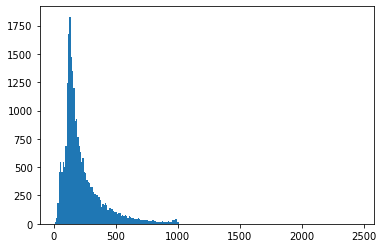

In [222]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [223]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [224]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

<ipython-input-224-27b1b5540537>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
<ipython-input-224-27b1b5540537>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [225]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [226]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [227]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1714112   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
______________________________________________

In [228]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 5s 11ms/step - loss: 0.6216 - accuracy: 0.6728 - val_loss: 0.4264 - val_accuracy: 0.8301
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.3163 - accuracy: 0.8732 - val_loss: 0.3051 - val_accuracy: 0.8702
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1959 - accuracy: 0.9281 - val_loss: 0.2910 - val_accuracy: 0.8788
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.1176 - accuracy: 0.9626 - val_loss: 0.3065 - val_accuracy: 0.8764
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0629 - accuracy: 0.9838 - val_loss: 0.3358 - val_accuracy: 0.8743
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0300 - accuracy: 0.9947 - val_loss: 0.3708 - val_accuracy: 0.8723
Epoch 7/10
196/196 [==============================] - 2s 11ms/step - loss: 0.0135 - accuracy: 0.9986 - val_loss: 0.4051 - val_accuracy: 0.8717
Ep

**Задание** Подсчитайте качество модели на тесте

In [230]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 2s 3ms/step - loss: 0.4784 - accuracy: 0.8698


[0.4783836007118225, 0.8697999715805054]

Если обучить на предобработанном ner_lemmas качество будет лучше, но времени уже маловато осталось, скоро колаб просто выкинет из среды